## The main workshop challenge

This Notebook demonstrates some solutions for unsupervised fraud detection strategies. 

Labels are not used for tuning. 



In [15]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN   

sys.path.append("..") #to enable importing from ../outlierutils

In [54]:
from outlierutils import plot_top_N, plot_outlier_scores, LabelSubmitter

In [3]:
data_path = '../data/'
x_fraud = pd.read_pickle(os.path.join(data_path, 'x_fraud.pkl'))
y_fraud = pd.read_pickle(os.path.join(data_path, 'y_fraud.pkl'))

print('Shape of the X-data: {}'.format(x_fraud.shape))
print('Mean of the y variable: {:.2%}'.format(y_fraud.mean()))

Shape of the X-data: (200000, 434)
Mean of the y variable: 3.01%


In [21]:
def label_encoding(df, columns=None):
    if columns is None:
        columns = df.columns
    for col in columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df.loc[:, col] = le.transform(list(df.loc[:, col].astype(str).values))
    return df

def median_imputation(df, median_impute_limit=0.95, impute_val=-999):
    """ inf/nan Values that occur more often than median_impute_limit are imputed with the median
    when less often, they are imputed by impute_val. 
    Set median_impute_limit to 0 to always do median imputation
    """
    df = df.replace([np.inf, -np.inf], np.nan)
    for col in df.columns:
        if not df[col].dtype == 'object':
            mean_nan = df[col].isna().mean()
            if mean_nan > median_impute_limit: # then, impute by median
                df[col] = df[col].fillna(df[col].median())
            elif mean_nan > 0 and mean_nan <= median_impute_limit:
                df[col] = df[col].fillna(impute_val)
                
    return df

In [5]:
column_groups = {'card': [c for c in x_fraud.columns if c.startswith('card')],
                   'addr': [c for c in x_fraud.columns if c.startswith('addr')],
                   'dist1': ['dist1', 'dist2'],
                   'C' : [c for c in x_fraud.columns if c.startswith('C')],
                   'D' : [c for c in x_fraud.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in x_fraud.columns if c.startswith('M')],
                   'id' : [c for c in x_fraud.columns if c.startswith('id')],   
                   'V': [c for c in x_fraud.columns if c.startswith('V')],
                   'trans': [c for c in x_fraud.columns if c.startswith('Trans')]}


### Card columns

These are supposedly categorical, but have many unique values. Leave numerical, except for card4 and card6 (that have only 4 unique values). Do a mode fill on the NaN columns

In [6]:
card_cols = pd.get_dummies(x_fraud[column_groups['card']], columns=['card4', 'card6'], drop_first=True)

In [7]:
card_cols = card_cols.fillna(card_cols.mode().iloc[0]) #NB: iloc: fillna needs a 1-D object to be applied on columns

In [8]:
# Check: No Nan's, no text
assert not card_cols.isna().sum().sum(), 'NaNs still present'
assert not [c for c in card_cols.dtypes if c==object]

In [9]:
card_colnames_dummies = [col for col in card_cols.columns if col.startswith('card4') or col.startswith('card6')]
card_colnames_numeric = [col for col in card_cols.columns if col not in card_colnames_dummies]

### Dist columns

These represent "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”, thus are numeric

In [10]:
x_fraud[column_groups['dist1']].isna().mean()
dist_cols = pd.concat((x_fraud[['dist1']].fillna(x_fraud[['dist1']].median()), 
                        x_fraud[['dist1']].isna().astype(int).rename(columns={'dist1': 'dist1_nan'}),
                      x_fraud[['dist2']].fillna(x_fraud[['dist2']].median()), 
                        x_fraud[['dist2']].isna().astype(int).rename(columns={'dist2': 'dist2_nan'})), axis=1)

In [40]:
dist_cols.shape

(200000, 4)

### Address Columns 
According to the description, these columns are categorical. Do not seem very useful, judging at the many levels present. 
Skip these. 


In [11]:
x_fraud[column_groups['addr']].nunique()


addr1    273
addr2     57
dtype: int64

### C- columns

The C-columns are numerical, but can easily be compressed

In [12]:
print(x_fraud[column_groups['C']].dtypes.value_counts())
print(x_fraud[column_groups['C']].var())

float32    14
dtype: int64
C1     48411.460938
C2     65572.851562
C3         0.022945
C4     12482.175781
C5       532.293579
C6     12807.372070
C7     11195.851562
C8     26310.460938
C9       235.686508
C10    26480.740234
C11    23780.302734
C12    22048.548828
C13    28602.167969
C14     5625.250977
dtype: float32


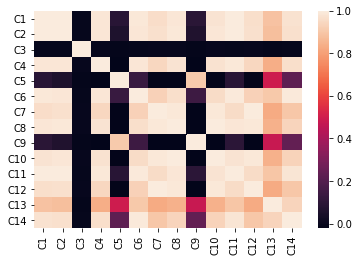

In [73]:
sns.heatmap(x_fraud[column_groups['C']].corr());

In [23]:
C_original_cols = preproc_scale(x_fraud[column_groups['C']])
pca = PCA(n_components=3, whiten=True)
C_transformed_cols = pca.fit_transform(C_original_cols)

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) # NB: 3 variables recovers 98% of variance


[75.47 90.85 97.99]


### D- columns

D1-D15: timedelta, such as days between previous transaction, etc.

In [26]:
D_imputed = median_imputation(x_fraud[column_groups['D']].copy(), median_impute_limit=0)
D_original = preproc_scale(D_imputed)

pca = PCA(n_components=10, whiten=True)
D_transformed = pca.fit_transform(D_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 
# Quite many components are needed for good reconstruction. 
# Take only 4 columns to reconstruct 60%
D_transformed = D_transformed[:, :4]

[27.21 44.32 52.33 59.08 65.58 71.95 78.01 83.27 87.75 91.36]


### V- columns
There are 339 V-columns, that are supposedly very relevant. 
"Vesta engineered rich features, including ranking, counting, and other entity relations." All numerical. 

In [27]:
x_fraud[column_groups['V']].shape

(200000, 339)

In [30]:
V_original = median_imputation(x_fraud[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)
pca = PCA(n_components=25, whiten=True)
V_transformed = pca.fit_transform(V_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 
# With 25 columns (compression of more than 90%), we recover 73% of the signal

[10.78 19.34 26.16 31.89 36.87 40.61 44.05 47.12 49.73 52.23 54.38 56.48
 58.47 60.18 61.84 63.34 64.69 65.89 67.02 68.09 69.11 70.08 71.02 71.94
 72.78]


### Transaction amount

In [33]:
x_fraud[column_groups['trans'][2]].describe()

count    200000.000000
mean        129.828903
std         207.672272
min           0.292000
25%          43.924999
50%          74.000000
75%         125.000000
max        5278.950195
Name: TransactionAmt, dtype: float64

In [43]:
log_trans_amount = np.log10(1 + x_fraud.loc[:, [column_groups['trans'][2]]])


In [44]:
x_fraud_processed = np.concatenate([card_cols[card_colnames_dummies].values, 
                                  dist_cols.values,
                                  C_transformed_cols,
                                  D_transformed,
                                  V_transformed,
                                  log_trans_amount], 
                                   axis=1)

In [46]:
pd.DataFrame(data=x_fraud_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000
mean,0.013170,0.303285,0.658555,0.31099,0.688870,0.000055,49.352595,0.658170,44.660740,0.922405,...,-6.909318e-16,-1.342926e-15,2.849347e-15,-1.227107e-15,8.014922e-16,4.691003e-16,-2.590355e-15,1.314007e-15,-1.633680e-15,1.901053
std,0.114003,0.459678,0.474196,0.46290,0.462957,0.007416,233.490245,0.474324,162.783195,0.267534,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.398599
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.148762e+01,-2.576297e+01,-2.431370e+01,-1.794091e+01,-1.982840e+01,-3.781235e+01,-2.620229e+01,-1.866196e+01,-2.508944e+01,0.111263
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,9.000000,0.000000,28.000000,1.000000,...,-3.064748e-01,-1.620154e-01,-2.994783e-01,-4.415571e-01,-3.690877e-01,-2.056621e-01,-2.222345e-01,-2.205960e-01,-4.164620e-01,1.652488
50%,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000,9.000000,1.000000,28.000000,1.000000,...,1.376992e-01,7.193080e-02,-7.530783e-02,2.731690e-02,-1.012318e-01,-4.154810e-02,-4.496799e-02,-8.776521e-03,5.330256e-02,1.875061
75%,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,9.000000,1.000000,28.000000,1.000000,...,3.102290e-01,3.072149e-01,2.132128e-01,4.755832e-01,3.838776e-01,1.472332e-01,2.068800e-01,1.610066e-01,3.590523e-01,2.100370
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,7068.000000,1.000000,9103.000000,1.000000,...,3.612821e+01,4.685504e+01,3.406069e+01,2.667760e+01,3.347541e+01,5.705766e+01,4.293276e+01,6.437960e+01,3.426390e+01,3.722630


In [50]:
from keras.optimizers import Adam
adam = Adam(learning_rate=1.E-4)
clf = AutoEncoder(
    hidden_neurons=[30, 20, 30],
    hidden_activation='elu',
    output_activation='linear',
    optimizer=adam,
    epochs=4,
    batch_size=16,
    dropout_rate=0.2,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True,
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [51]:
clf.fit(x_fraud_processed)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 43)                1892      
_________________________________________________________________
dropout_6 (Dropout)          (None, 43)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 43)                1892      
_________________________________________________________________
dropout_7 (Dropout)          (None, 43)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.2, epochs=4,
      hidden_activation='elu', hidden_neurons=[30, 20, 30],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7ff79451fa60>,
      optimizer=<keras.optimizers.Adam object at 0x7ff74c2ec6d8>,
      output_activation='linear', preprocessing=True, random_state=1,
      validation_size=0.1, verbose=1)

In [55]:
y_train_scores = clf.decision_scores_  # raw outlier scores
y_train_scores = np.clip(y_train_scores, 0, 50) # for visual purposes

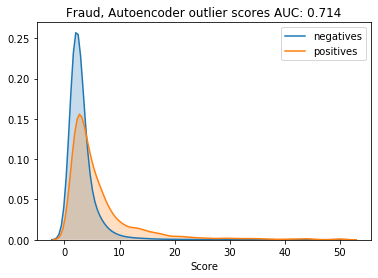

In [57]:
res = plot_outlier_scores(y_fraud.values, y_train_scores, 
                          bw=1.0, title='Fraud, Autoencoder outlier scores')

In [ ]:
ifo = IsolationForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_fraud)
kdd_isof_scores = - ifo.decision_function(x_fraud)

In [ ]:
res = plot_outlier_scores(y_fraud.values, kdd_isof_scores, 
                          bw=1.0, title='Fraud, Isol outlier scores')